In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('post_abtest_data.csv', parse_dates=['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            101500 non-null  int64         
 1   date               101500 non-null  datetime64[ns]
 2   app_opened         101500 non-null  int64         
 3   group              101500 non-null  object        
 4   price_seen         101500 non-null  int64         
 5   order_made         101500 non-null  int64         
 6   surge              92358 non-null   object        
 7   os                 101500 non-null  object        
 8   user_cancelled     70157 non-null   float64       
 9   city_center_order  70157 non-null   float64       
 10  groups             101500 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 8.5+ MB


In [3]:
#проверим вхождение одного user_id и в Test и в Control
df_check = data[['user_id', 'group']]
df_check_no_dupl = df_check.drop_duplicates()
df_check_no_dupl.user_id.value_counts().sort_values(ascending=False)

#одновременных вхождений в тест и контрол нет

867689    1
382672    1
139455    1
416988    1
682337    1
         ..
340213    1
352605    1
216082    1
777242    1
811817    1
Name: user_id, Length: 24224, dtype: int64

### Гипотеза: 
Если мы понизим коэффициент "surge" в период повышенного спроса, то конверсия price-to-order в этот период возрастет.

In [4]:
#фильтруем данные по признаку "surge" и "показу цены"
data_surge = data.query("surge == 'surge' and price_seen == 1")

#удалим лишние столбцы
data_surge = data_surge.drop(columns={'app_opened','os', 'user_cancelled', 'city_center_order', 'groups'})

In [5]:
#разбиваем выборку на 7 частей по дате
labels=['1', '2','3', '4', '5', '6', '7']

data_surge['day_number'] = pd.cut(data_surge['date'], bins=7 , labels=labels)
data_surge['day_number'] = data_surge['day_number'].astype('int') #преобразовали столбец категорий в int-тип
data_surge.head()

,user_id,date,group,price_seen,order_made,surge,day_number
1,867689,2020-05-29,Control,1,0,surge,5
2,867689,2020-05-25,Control,1,1,surge,1
3,752172,2020-05-29,Control,1,1,surge,5
5,486559,2020-05-25,Control,1,0,surge,1
8,486559,2020-05-28,Control,1,0,surge,4


In [6]:
#функция проведения t-теста по дням
def test_by_day(df, day_num, alpha=0.05):
  
    global p_value_1 #чтобы вывести p_value в список для дальнейшего построения графика
    day_1 = df.query("day_number == @day_num")

  #находим конверсию по каждому пользователю (получим user_id без повторений)
    day_1_by_user = day_1.groupby('user_id', as_index=False) \
                              .agg({'price_seen':'sum', \
                                    'order_made':'sum', \
                                    'group'     :'max'})
    day_1_by_user['price_to_order_conv'] = round(day_1_by_user.order_made / day_1_by_user.price_seen, 2) *100

  #разделяем на 2 группы
    group_0 = day_1_by_user.query("group == 'Control'")
    group_1 = day_1_by_user.query("group == 'Test'")


  #выводим хорактеристики выборок
    print('кол-во наблюдений в group_control =', len(group_0))
    print('кол-во наблюдений в group_test =', len(group_1))
    print('общее кол-во наблюдений =', len(group_1) + len(group_0)) #проверка что никто не потерялся
    print('средняя поюзерная конверсия (контрольная группа) =', round(group_0.price_to_order_conv.mean(),2))
    print('средняя поюзерная конверсия (тестовая группа) =', round(group_1.price_to_order_conv.mean(),2))

    #проводим t-test
    t = ttest_ind(group_0['price_to_order_conv'], group_1['price_to_order_conv'])
    p_value_1 = t.pvalue
    print('p-value =', round(p_value_1, 3))
    print()
  
    if t.pvalue > alpha:
        print(f'p-value {round(t.pvalue, 2)} > alpha {round(alpha, 2)}\nПринимаем H_0 - средние выборок РАВНЫ.\nЗначимых изменений нет.')
    else:
        print(f'p-value {round(t.pvalue, 2)} < alpha {round(alpha, 2)}\nОтклоняем H_0 - средние выборок НЕ РАВНЫ\nНаблюдается значимое изменение.')

    print('________________________________________________________________________')
 

In [7]:
p_values = []
for i in range(1,8):
    print(f'--- t-test {i}го дня ---')
    test_by_day(data_surge, i)
    p_values.append(p_value_1)
    print()

--- t-test 1го дня ---
кол-во наблюдений в group_control = 1867
кол-во наблюдений в group_test = 1916
общее кол-во наблюдений = 3783
средняя поюзерная конверсия (контрольная группа) = 58.48
средняя поюзерная конверсия (тестовая группа) = 63.6
p-value = 0.001

p-value 0.0 < alpha 0.05
Отклоняем H_0 - средние выборок НЕ РАВНЫ
Наблюдается значимое изменение.
________________________________________________________________________

--- t-test 2го дня ---
кол-во наблюдений в group_control = 1876
кол-во наблюдений в group_test = 1871
общее кол-во наблюдений = 3747
средняя поюзерная конверсия (контрольная группа) = 62.0
средняя поюзерная конверсия (тестовая группа) = 61.48
p-value = 0.739

p-value 0.74 > alpha 0.05
Принимаем H_0 - средние выборок РАВНЫ.
Значимых изменений нет.
________________________________________________________________________

--- t-test 3го дня ---
кол-во наблюдений в group_control = 1898
кол-во наблюдений в group_test = 1909
общее кол-во наблюдений = 3807
средняя поюз

In [8]:
#выведем значения p-value
p_values

[0.0009735385910968797,
 0.7386004107192503,
 0.1653384106031448,
 0.1985099342129266,
 0.5077296638551498,
 0.05591127112443488,
 0.5232772310240463]

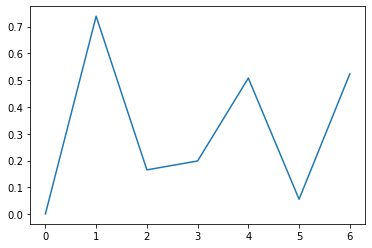

In [9]:
#график ежедневного p_value
plt.plot(p_values)

### Вывод
Судя по графику дневных значений p-value, только в первый день мы наблюдаем результат внедрения новой опции в приложение (в этот день p-value < alpha, значит имеются различия между группами, а при проведении аб-теста мы этого и ждем). В остальных же днях различий между группами не наблюдается. Значит, новая опция накого воздействия на конверсию не оказывает. Раскатывать на всех пользователей её не будем.

Изначальная конверсия в заказ в период сурджа была = 74%, после ввнедрения опции в приложение, ожидаем новую конверсию +10пп. Выбрали alpha=0.05, beta=0.2 и получили размер каждой выборки (тест и контрол) по 322 пользователя.

При проведении аб-теста каждый день в каждой из выборок было больше 1800 наблюдений. Это значит, что мощности теста хватает для определения изменений там, где они есть. А значит тест отработал корректно и показал, что модернизация не изменила поведение пользователей.

### Проведем A/B-тест через накопительное значение p-value

In [12]:
#функция проведения t-теста
def test_by_day_cumul(df, alpha=0.05):
  
    global p_value_1 #чтобы вывести p_value в список для дальнейшего построения графика
    day_1 = df

  #находим конверсию по каждому пользователю (получим user_id без повторений)
    day_1_by_user = day_1.groupby('user_id', as_index=False) \
                              .agg({'price_seen':'sum', \
                                    'order_made':'sum', \
                                    'group'     :'max'})
    day_1_by_user['price_to_order_conv'] = round(day_1_by_user.order_made / day_1_by_user.price_seen, 2) *100

  #разделяем на 2 группы
    group_0 = day_1_by_user.query("group == 'Control'")
    group_1 = day_1_by_user.query("group == 'Test'")


  #выводим хорактеристики выборок
    print('кол-во наблюдений в group_control =', len(group_0))
    print('кол-во наблюдений в group_test =', len(group_1))
    print('общее кол-во наблюдений =', len(group_1) + len(group_0)) #проверка что никто не потерялся
    print('средняя поюзерная конверсия (контрольная группа) =', round(group_0.price_to_order_conv.mean(),2))
    print('средняя поюзерная конверсия (тестовая группа) =', round(group_1.price_to_order_conv.mean(),2))

  #проводим t-test
    t = ttest_ind(group_0['price_to_order_conv'], group_1['price_to_order_conv'])
    p_value_1 = t.pvalue
    print('p-value =', round(p_value_1, 3))
    print()
  
    if t.pvalue > alpha:
        print(f'p-value {round(t.pvalue, 2)} > alpha {round(alpha, 2)}\nПринимаем H_0 - средние выборок РАВНЫ.\nЗначимых изменений нет.')
    else:
        print(f'p-value {round(t.pvalue, 2)} < alpha {round(alpha, 2)}\nОтклоняем H_0 - средние выборок НЕ РАВНЫ\nНаблюдается значимое изменение.')

    print('________________________________________________________________________')

In [13]:
#Распределим данные накопительным итогом

d1 = data_surge.query("day_number in [1]")
d2 = data_surge.query("day_number in [1,2]")
d3 = data_surge.query("day_number in [1,2,3]")
d4 = data_surge.query("day_number in [1,2,3,4]")
d5 = data_surge.query("day_number in [1,2,3,4,5]")
d6 = data_surge.query("day_number in [1,2,3,4,5,6]")
d7 = data_surge.query("day_number in [1,2,3,4,5,6,7]")

days = [d1, d2, d3, d4, d5, d6, d7]

In [15]:
p_values_2 = []
n = 1
for i in days:
  
    print(f'--- t-test {n}-го дня ---')
    test_by_day_cumul(i)
    p_values_2.append(p_value_1)
    n += 1
    print()

--- t-test 1-го дня ---
кол-во наблюдений в group_control = 1867
кол-во наблюдений в group_test = 1916
общее кол-во наблюдений = 3783
средняя поюзерная конверсия (контрольная группа) = 58.48
средняя поюзерная конверсия (тестовая группа) = 63.6
p-value = 0.001

p-value 0.0 < alpha 0.05
Отклоняем H_0 - средние выборок НЕ РАВНЫ
Наблюдается значимое изменение.
________________________________________________________________________

--- t-test 2-го дня ---
кол-во наблюдений в group_control = 3438
кол-во наблюдений в group_test = 3467
общее кол-во наблюдений = 6905
средняя поюзерная конверсия (контрольная группа) = 60.23
средняя поюзерная конверсия (тестовая группа) = 62.66
p-value = 0.031

p-value 0.03 < alpha 0.05
Отклоняем H_0 - средние выборок НЕ РАВНЫ
Наблюдается значимое изменение.
________________________________________________________________________

--- t-test 3-го дня ---
кол-во наблюдений в group_control = 4819
кол-во наблюдений в group_test = 4829
общее кол-во наблюдений = 964

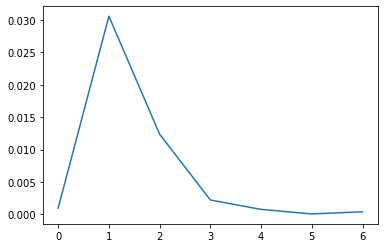

In [16]:
#выведем накопительные значения p-value
p_values_2
plt.plot(p_values_2)

### Вывод
По куммулятивному p-value, каждый день наблюдается значение меньше alpha, что говорит о различии групп и мы делаем вывод, что новая опция действительно оказывает влияние на конверсию в покупку.

Ниже приведены значения конверсий. Если учитывать что аб-тест прошел успешно и в итоге получили значимую разницу, то уменьшение коэфф сурджа даже ухудшило конверсию на 2пп. И в этом случае мы тоже не будем раскатывать эту фичу на всех пользователей.

In [17]:
#средняя поюзерная конверсия в заказ за первый день
d1 = d1.groupby('user_id', as_index=False) \
                              .agg({'price_seen':'sum', \
                                    'order_made':'sum', \
                                    'group'     :'max'})
                              
d1['price_to_order_conv'] = round(d1.order_made / d1.price_seen, 2) *100

d1_t = d1.query("group == 'Test'")
d1_c = d1.query("group == 'Control'")

print('d1_test_conv_mean = ', round(d1_t.price_to_order_conv.mean(),2))
print('d1_control_conv_mean = ', round(d1_c.price_to_order_conv.mean(),2))

d1_test_conv_mean =  63.6
d1_control_conv_mean =  58.48


In [18]:
#средняя поюзерная конверсия в заказ за седьмой день
d7 = d7.groupby('user_id', as_index=False) \
                              .agg({'price_seen':'sum', \
                                    'order_made':'sum', \
                                    'group'     :'max'})
                              
d7['price_to_order_conv'] = round(d7.order_made / d7.price_seen, 2) *100

d7_t = d7.query("group == 'Test'")
d7_c = d7.query("group == 'Control'")

print('d7_test_conv_mean = ', round(d7_t.price_to_order_conv.mean(),2))
print('d7_control_conv_mean = ', round(d7_c.price_to_order_conv.mean(),2))

d7_test_conv_mean =  61.83
d7_control_conv_mean =  59.55
